In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from urllib.parse import quote, unquote
from bs4 import BeautifulSoup
from collections import Counter
import seaborn as sns
from statistics import mean
from matplotlib.colors import LogNorm

### Reading the data into dataframes

In [272]:
articles = pd.read_csv('wikispeedia_paths-and-graph/articles.tsv', comment='#', delimiter='\t', encoding='utf8', 
                                    names=['article'])
categories = pd.read_csv('wikispeedia_paths-and-graph/categories.tsv', comment='#', delimiter='\t',
                                    names=['article', 'category'])
links = pd.read_csv('wikispeedia_paths-and-graph/links.tsv', comment='#', delimiter='\t', 
                                    names=['article', 'linkTarget'])  
finished_paths = pd.read_csv('wikispeedia_paths-and-graph/paths_finished.tsv', comment='#', delimiter='\t', 
                                    names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
unfinished_paths = pd.read_csv('wikispeedia_paths-and-graph/paths_unfinished.tsv', comment='#', delimiter='\t',
                                    names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])

Apply decoding on articles

Note: article names stored in df are decdoed but with underscores (_) instead of spaces ( )

In [273]:
articles['article'] = articles['article'].apply(unquote) # unquote to decode the article names
categories['article'] = categories['article'].apply(unquote)
links = links.applymap(unquote)
links.head(5)

,article,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


For every article, "links" stores all the articles it outlinks in a dataframe. Every row can be interpreted as containing a directed edge from the entry in column "article" to the entry in column "linkTarget".

"links22" is an updated version of "links" where the articles used are from 2022

In [274]:
links22 = pd.read_csv('Wiki_2022/links22.tsv', comment='#', delimiter='\t', names=['article', 'linkTarget']).applymap(unquote)
links22.head()

,article,linkTarget
0,linkSource,linkTarget
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Isle_of_Man
3,Áedán_mac_Gabráin,Genealogy
4,Áedán_mac_Gabráin,Bede


In [275]:
# Set indices
articles.set_index('article', inplace=True)
categories.set_index('article', inplace=True)
finished_paths.set_index('hashedIpAddress', inplace=True)
unfinished_paths.set_index('hashedIpAddress', inplace=True)

In [276]:
# Create df with all paths
paths_combined = pd.concat([finished_paths, unfinished_paths])
paths_combined.head(5)
print(len(finished_paths.index))

51318


In [277]:
# Filter out all paths with <
finished_paths_with_back = finished_paths.loc[finished_paths.path.str.contains('<')]

def get_associated_articles(path):
    article_list = path.split(';')
    index = article_list.index('<')
    return article_list[index-1], article_list[index+1]
    
# Add columns of associated articles before and after <
# TODO: get rid of warnings
finished_paths_with_back['article1'], finished_paths_with_back['article2'] = \
    zip(*finished_paths_with_back['path'].map(get_associated_articles))
finished_paths_with_back.head(5)

/var/folders/gg/nvlghfjs75g8s2cktfy2rbd40000gn/T/ipykernel_2599/3853467544.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finished_paths_with_back['article1'], finished_paths_with_back['article2'] = \
/var/folders/gg/nvlghfjs75g8s2cktfy2rbd40000gn/T/ipykernel_2599/3853467544.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finished_paths_with_back['article1'], finished_paths_with_back['article2'] = \


,timestamp,durationInSec,path,rating,article1,article2
hashedIpAddress,,,,,,
4cb0068c36658716,1248654953,253,14th_century;Time;Science;Nature;Weather;Sunli...,3.0,Sunlight,Sun
0d57c8c57d75e2f5,1283956474,391,14th_century;Renaissance;Empiricism;Nature;Wea...,5.0,Sunlight,Rain
0d57c8c57d75e2f5,1290753904,432,14th_century;Renaissance;Leonardo_da_Vinci;Wat...,NaN,Cloud,<
03dc907932cecfc5,1336436263,387,14th_century;Europe;Republic_of_Ireland;<;<;Eu...,2.0,Republic_of_Ireland,<
46021cc81bd7069a,1343940479,246,14th_century;Time;Physics;<;Day;Sun;Sunlight;U...,NaN,Physics,Day


In [278]:
print(f"Number of finished paths containing a back-edge: {len(finished_paths_with_back.index)}")

Number of finished paths containing a back-edge: 8995


In [279]:
# Functions for accessing article data
# Return a list containing plaintext content of wikipedia article
def get_plaintext(name):
    file_path = 'plaintext_articles/' + quote(name) + '.txt'
    with open(file_path, encoding='utf-8') as file:
        #first 5 lines are comments and titles 
        lines = file.readlines()[5:] 
        return list(map(str.strip, lines))

# Return prettified html content of wikipedia article
def get_html(name):
    file_path = 'wpcd/wp/' + name[0] + '/' + quote(name) + '.htm'
    with open(file_path) as file:
        html_doc = file.read()
        soup = BeautifulSoup(html_doc, 'html.parser')
        return soup.prettify()

# Exploratory Data Analysis

In [280]:
# Exploratory Data Analysis
n_articles = len(articles)
print(f'The number of articles is: {n_articles}')


The number of articles is: 4604


## Distributions of Data

### Incoming and Outgoing edges in Wikipedia

In [287]:
def edge_distributions(edges, incoming=True, old=True):
    '''
    Plots the distributions of the number of incoming/outgoing edges for each article for the 2009 and 2022 datasets.
    
    :param edges: dataframe containing number of edges (either incoming or outgoing)
    :param incoming: boolean, True if incoming edges, False if outgoing edges
    :param old: boolean, True if old dataset, False if new dataset
    '''
    articles_edges = (articles.copy(deep=True).join(edges).fillna(0))

    if incoming:
        articles_edges_lt = articles_edges.article
    else:
        articles_edges_lt = articles_edges.linkTarget
    mean_links = articles_edges_lt.mean()
    max_links = articles_edges_lt.max()
    num_leaves = (articles_edges_lt == 0).sum()
    if old:
        print(f'The mean number of inlinks is: {mean_links:.2f}')
        print(f'The maximum number of inlinks on any page is: {max_links}. This is the article on {articles_edges_lt[articles_edges_lt==max_links].index[0]}.')
        print(f'The number of pages without any inlinks is: {num_leaves}')
    else:
        print(f'The mean number of inlinks in 2022 is: {mean_links:.2f}')
        print(f'The maximum number of inlinks in 2022 on any page is: {max_links}. This is the article on {articles_edges_lt[articles_edges_lt==max_links].index[0]}.')
        print(f'The number of pages without any inlinks in 2022 is: {num_leaves}')


    bins = [i for i in range(int(max(articles_edges_lt)+1))]
    return articles_edges, bins

### Inlinks
Distibutions of inlinks, original vs 2022

The mean number of inlinks is: 26.04
The maximum number of inlinks on any page is: 1551.0. This is the article on United_States.
The number of pages without any inlinks is: 469
The mean number of inlinks in 2022 is: 49.43
The maximum number of inlinks in 2022 on any page is: 1064.0. This is the article on United_States.
The number of pages without any inlinks in 2022 is: 467


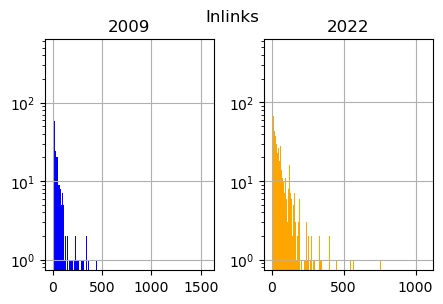

In [288]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
plt.suptitle('Inlinks')
art1, bins1 = edge_distributions(links.groupby(['linkTarget'])['article'].count(), True)
art2, bins2 = edge_distributions(links22.groupby(['linkTarget'])['article'].count(), True, False)
art1.hist(bins=bins1, ax=axes[0], log=True, color='blue' ,label='2009')
art2.hist(bins=bins2, ax=axes[1], log=True, color='orange', label='2022')
axes[0].set_title('2009')
axes[1].set_title('2022')
plt.show()

The mean number of inlinks is: 26.04
The maximum number of inlinks on any page is: 294.0. This is the article on United_States.
The number of pages without any inlinks is: 17
The mean number of inlinks in 2022 is: 49.43
The maximum number of inlinks in 2022 on any page is: 367.0. This is the article on Europe.
The number of pages without any inlinks in 2022 is: 11


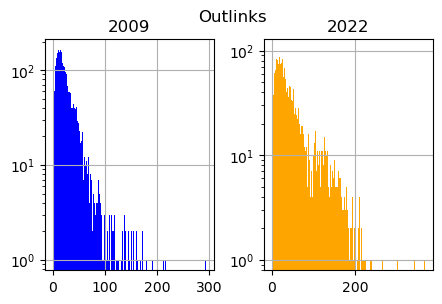

In [289]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
plt.suptitle('Outlinks')
art1, bins1 = edge_distributions(links.groupby(['article'])['linkTarget'].count(), False)
art2, bins2 = edge_distributions(links22.groupby(['article'])['linkTarget'].count(), False, False)
art1.hist(bins=bins1, ax=axes[0], log=True, color='blue' ,label='2009')
art2.hist(bins=bins2, ax=axes[1], log=True, color='orange', label='2022')
axes[0].set_title('2009')
axes[1].set_title('2022')
plt.show()

We have used log axes to plot the distributions since the distributions are heavily skewed to the right. The distributions are also similar, but we can see that in general pages got more inlinks as well as outlinks in 2022.

### Categories
For our analysis, we have decided to use 15 categories. These categories are general enough to allow us to interpret them but at the same time specific enough to allow us to do a meaningful analysis.

In [290]:
# The main categories that we are interested in (we have chosen these ourselves)
wiki_2009_categories = pd.read_csv('./wikispeedia_paths-and-graph/categories.tsv', delim_whitespace=True, names=['article', 'category'], comment='#')
wiki_2009_categories = wiki_2009_categories.groupby('article').sample(1)
wiki_2009_categories['category'] = wiki_2009_categories['category'].str.extract(r'subject\.([a-zA-Z]*)')
wiki_2009_categories = wiki_2009_categories.set_index('article')
article_cat = wiki_2009_categories.to_dict()['category']

### Getting Intimate with the Data
We want to see how many articles are in each category

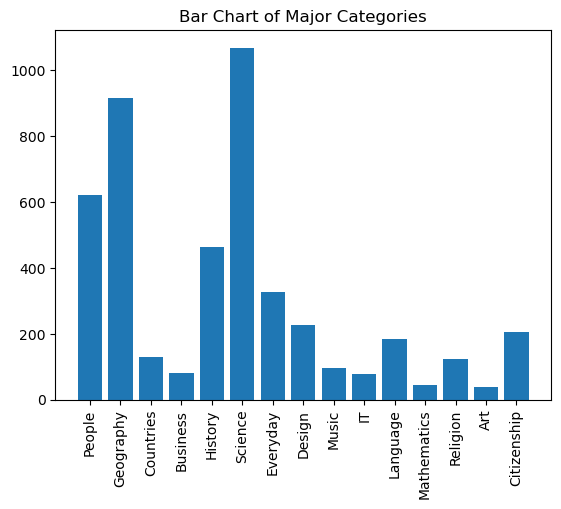

In [76]:
labels, values = zip(*Counter(article_cat.values()).items())
indexes = np.arange(len(labels))
width = 0.8

plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation=90)
plt.title("Bar Chart of Major Categories")
plt.show()

Converting the articles to categories in the links dataframe

In [137]:
categories = list(set(article_cat.values()))
cats_df = links.copy(deep=True)
cats_df['article'] = cats_df['article'].apply(lambda x: article_cat[x] if x in article_cat else 'NA') 
cats_df['linkTarget'] = cats_df['linkTarget'].apply(lambda x: article_cat[x] if x in article_cat else 'NA') 
cats_df.head()

,article,linkTarget
0,People,History
1,People,People
2,People,History
3,People,Citizenship
4,People,Countries


Computing the adjacency matrix when the articles are converted to categories

In [150]:
cats_df.groupby(['article', 'linkTarget']).size().unstack(fill_value=0)

linkTarget,Art,Business,Citizenship,Countries,Design,Everyday,Geography,History,IT,Language,Mathematics,Music,NA,People,Religion,Science
article,,,,,,,,,,,,,,,,
Art,121,5,28,63,30,34,184,152,3,55,3,12,0,199,56,60
Business,3,313,185,393,63,80,761,125,25,31,13,1,0,93,22,152
Citizenship,29,171,1147,1012,90,186,1892,693,39,201,35,16,0,588,239,361
Countries,25,274,656,1537,40,315,2646,619,4,313,6,27,0,209,231,271
Design,36,72,146,447,469,72,1415,397,42,69,14,9,0,258,44,465
Everyday,49,89,277,858,108,1216,2348,449,104,340,25,45,2,348,135,1068
Geography,123,630,1721,4526,524,1411,13418,2253,30,987,36,166,0,1128,739,2268
History,70,157,882,1517,287,284,3906,3230,14,338,26,32,0,1480,464,689
IT,1,35,51,40,30,16,82,11,383,48,37,3,0,61,1,62


<AxesSubplot: xlabel='linkTarget', ylabel='article'>

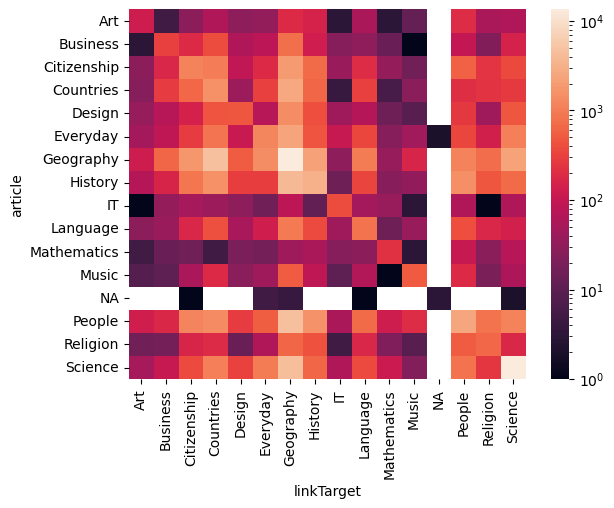

In [153]:
sns.heatmap(data=cats_df.groupby(['article', 'linkTarget']).size().unstack(fill_value=0), norm=LogNorm())

### Some Observations
1) *The Geography row is on average lighter than the Design row:*
This makes sense because the Geography row is more likely to be used by a player since it is easiest to think of when traversing from one page to the other, the player anticipates their next moves to be easier with this.

2) *Design to Geography has a darker colour than Geography to Design:*
This makes sense since people would move from Design, which is a domain with fewer and less natural connections to other categories, to Geography, a domain with many natural connections to other categories, but not the other way around

### Category-Wise Analysis
We check things like-
1. How many articles are there in each category?
2. Number of inlinks and outlinks for each category

In [293]:
# Return list of all articles in a category
def cat_wise(cats_link, cat):
    cats_link = cats_link[cats_link['category'] == cat].index
    return list(cats_link)

In [294]:
def get_plaintext(name):
    file_path = './plaintext_articles/' + name + '.txt'
    with open(file_path, encoding='utf-8') as file:
        #first 5 lines are comments and titles 
        lines = file.readlines()[5:] 
        return list(map(str.strip, lines))

def cat_wise_stats(cats_link, cat):
    titles = cat_wise(wiki_2009_categories, cat)
    word_count_ls = []

    for title in titles:
        word_count= sum([len(l.split()) for l in get_plaintext(title)])
        word_count_ls.append(word_count)

    inc = links.groupby(['linkTarget'])['article'].count()
    out = links.groupby(['article'])['linkTarget'].count()
    filt_inc = inc[[x in article_cat and article_cat[x] == cat for x in inc.index]]
    filt_out = out[[x in article_cat and article_cat[x] == cat for x in out.index]]
    avg_words = mean(word_count_ls)
    avg_in = filt_inc.mean()
    avg_out = filt_out.mean()
    print(f'The average number of words in a wikipedia article for category "{cat}" is: {avg_words:.2f}')
    print(f'The average number of inlinks for category "{cat}" is: {avg_in:.2f}')
    print(f'The average number of outlinks for category "{cat}" is: {avg_out:.2f}')
    print(f'The average number of words per inlink for category "{cat}" is: {avg_words/avg_in:.2f}')
    print(f'The average number of words per outlink for category "{cat}" is: {avg_words/avg_out:.2f}')

### Category-Wise Analysis

**Design**

In [301]:
cat_wise_stats(links, 'Design')

The average number of words in a wikipedia article for category "Design" is: 3001.08
The average number of inlinks for category "Design" is: 13.88
The average number of outlinks for category "Design" is: 17.99
The average number of words per inlink for category "Design" is: 216.22
The average number of words per outlink for category "Design" is: 166.86


**Geography**

In [302]:
cat_wise_stats(links, 'Geography')


The average number of words in a wikipedia article for category "Geography" is: 2937.44
The average number of inlinks for category "Geography" is: 44.08
The average number of outlinks for category "Geography" is: 33.00
The average number of words per inlink for category "Geography" is: 66.64
The average number of words per outlink for category "Geography" is: 89.03
